Til neste gang: mer analyse av dataen, "forstå dataen". Gjøre analyser slik at leser av dokumentet forstår hva vi gjør og hvorfor vi gjør det.

In [1]:
# These have to be installed through running "pip install -r requirements.txt"

import re # for regular expressions
import numpy as np # for numerical computation
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
import sklearn  # machine learning library
import nltk # natural language toolkit
import tensorflow as tf # deep learning library

from nltk.corpus import stopwords # to remove stopwords
from nltk.tokenize import word_tokenize # to tokenize
from nltk.stem import WordNetLemmatizer # to lemmatize
from nltk.sentiment.vader import SentimentIntensityAnalyzer # to analyze sentiment

from wordcloud import WordCloud # to visualize text
from PIL import Image # to load images

from gensim.test.utils import common_texts  # some example texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument  # doc2vec model

from sklearn.feature_extraction.text import TfidfVectorizer # to convert text to numbers 
from sklearn.ensemble import RandomForestClassifier # to build a model
from sklearn.linear_model import LogisticRegression # to build a model
from sklearn.neighbors import KNeighborsClassifier # to build a model
from sklearn.model_selection import train_test_split # to split the data
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix  # to evaluate the model
from sklearn.metrics import classification_report # to evaluate the model


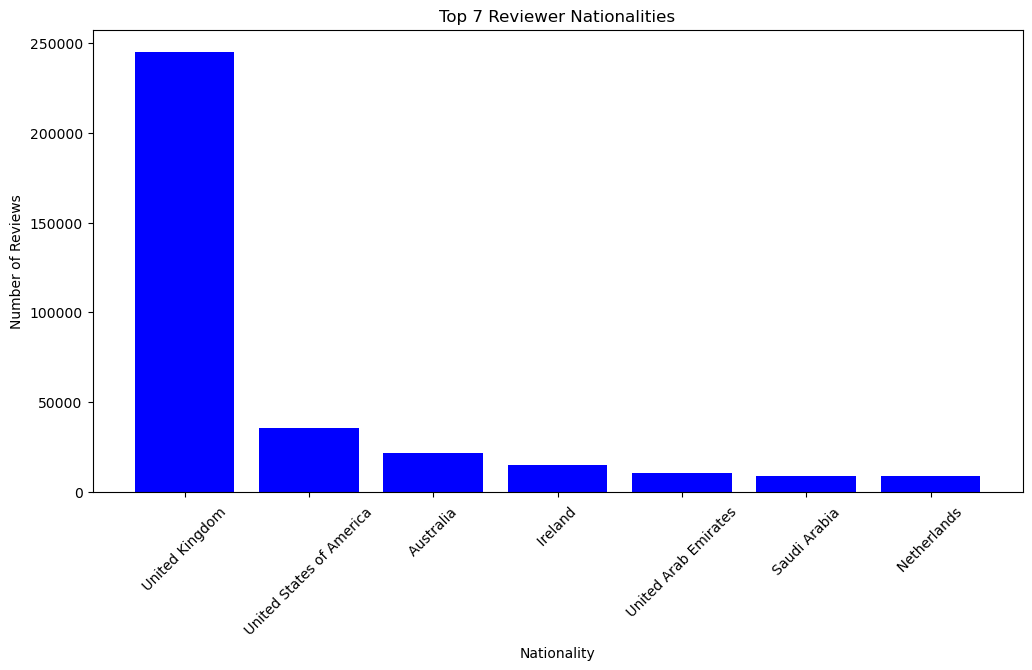

In [2]:
# Distrobution of nationality (top 7 nationalities)
df = pd.read_csv('Hotel_Reviews.csv')

top_nationalities = df['Reviewer_Nationality']. value_counts().head(7)

plt.figure(figsize=(12, 6))
plt.bar(top_nationalities.index, top_nationalities.values, color='blue')
plt.xticks(rotation=45)
plt.title("Top 7 Reviewer Nationalities")
plt.xlabel("Nationality")
plt.ylabel("Number of Reviews")
plt.show()

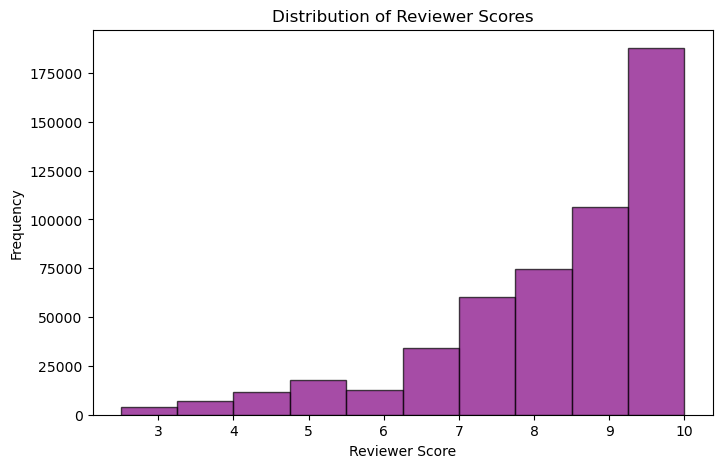

In [3]:
plt.figure(figsize=(8, 5))

# Review Score Distribution
plt.hist(df['Reviewer_Score'], bins=10, color="purple", edgecolor="black", alpha=0.7)
plt.title("Distribution of Reviewer Scores")
plt.xlabel("Reviewer Score")
plt.ylabel("Frequency")
plt.show()

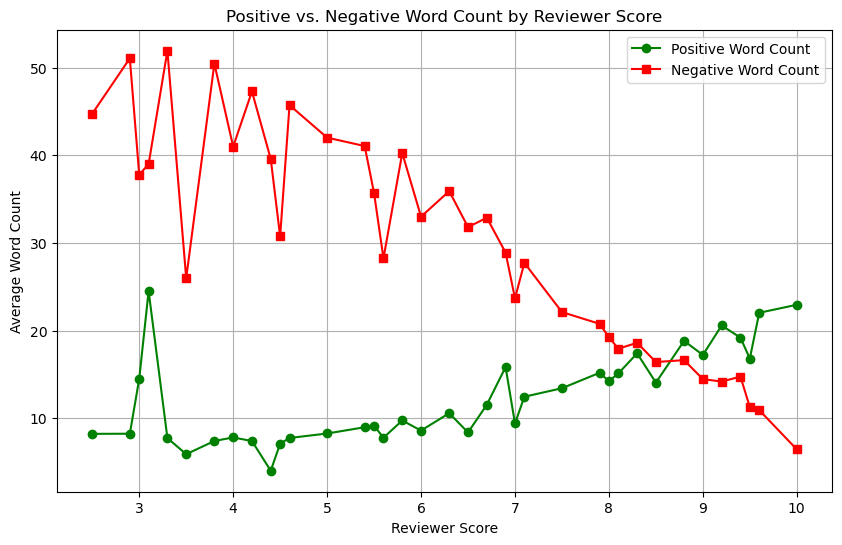

In [4]:
review_score_grouped = df.groupby("Reviewer_Score")[
    ["Review_Total_Positive_Word_Counts", "Review_Total_Negative_Word_Counts"]
].mean()

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both lines
ax.plot(review_score_grouped.index, review_score_grouped["Review_Total_Positive_Word_Counts"],
        marker="o", linestyle="-", color="green", label="Positive Word Count")

ax.plot(review_score_grouped.index, review_score_grouped["Review_Total_Negative_Word_Counts"],
        marker="s", linestyle="-", color="red", label="Negative Word Count")

# Labels and title
ax.set_xlabel("Reviewer Score")
ax.set_ylabel("Average Word Count")
ax.set_title("Positive vs. Negative Word Count by Reviewer Score")
ax.legend()
ax.grid(True)

# Show plot
plt.show()

In [5]:
# Storing the csv file as a pandas dataframe and sample 50/50 of the positive and negative scores

positive_reviews = df[df['Reviewer_Score'] > 8.5]
negative_reviews = df[df['Reviewer_Score'] < 8.5]

negative_sample = negative_reviews.sample(n=100000, random_state=42)
positive_sample = positive_reviews.sample(n=100000, random_state=42)

balanced_df = pd.concat([positive_sample, negative_sample])
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(balanced_df['Reviewer_Score'].apply(lambda x: 'positive' if x > 8.5 else 'negative').value_counts())

Reviewer_Score
positive    100000
negative    100000
Name: count, dtype: int64


In [6]:
def replace(cell): 
    if cell == "No Positive" or cell == "No Negative":
        return ""
    return cell

df['Negative_Review'] = df['Negative_Review'].apply(replace)
df['Positive_Review'] = df["Positive_Review"].apply(replace)

In [7]:
def combine_names(row):
    return f"{row['Positive_Review']} {row['Negative_Review']}"


df["Review"] = df.apply(combine_names, axis="columns")

In [8]:
df = df.drop(["Hotel_Address", "Additional_Number_of_Scoring", "Review_Date", "Average_Score", "Reviewer_Nationality", "Review_Total_Negative_Word_Counts", "Review_Total_Positive_Word_Counts", "Total_Number_of_Reviews_Reviewer_Has_Given", "Tags", "days_since_review", "lat", "lng", "Hotel_Name", "Total_Number_of_Reviews", "Negative_Review", "Positive_Review"], axis = "columns")
df

,Reviewer_Score,Review
0,7.5,We chose the hotel based on location as we wa...
1,9.2,Very comfortable rooms
2,6.3,Friendly staff and good location Very uncom...
3,8.8,The amenities in the room excellent nice view...
4,9.2,The staff were very helpful when I ask for ta...
...,...,...
199995,3.3,Not friendly staff moldy bathrooms just not ...
199996,8.3,Great breakfasts and really helpful staff Sta...
199997,6.7,When I made my booking I requested the cheap...
199998,8.3,Hotel location is good easy to access by publ...


In [9]:

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a single string
    processed_text = ' '.join(lemmatized_tokens)
    
    return processed_text

# Apply the preprocessing function to your DataFrame
df['Review'] = df['Review'].apply(preprocess_text)

In [10]:
# Adding TF-IDF values to find out the importance of words in the reviews
tfidf = TfidfVectorizer(min_df = 10) # Initialize the TfidfVectorizer with a minimum document frequency of 10
tfidf_result = tfidf.fit_transform(df['Review']).toarray() # Fit and transform the 'Review' column to compute TF-IDF values
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())# Convert the TF-IDF matrix into a DataFrame
tfidf_df.columns = ['word_' + str(x) for x in tfidf_df.columns] # Rename columns to avoid conflicts with existing column names
tfidf_df.index = df.index # Align the index of the TF-IDF DataFrame with the original DataFrame
df = pd.concat([df, tfidf_df], axis=1) # Concatenate the original DataFrame with the TF-IDF DataFrame
df.head()

,Reviewer_Score,Review,word_00,word_000,word_00am,word_00hrs,word_00pm,word_01,word_02,word_03,...,word_yuk,word_yum,word_yummy,word_zara,word_zero,word_ziggo,word_zip,word_zone,word_zoo,word_zuid
0,7.5,chose hotel based location wanted source item ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.2,comfortable room,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.3,friendly staff good location uncomfortable pil...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.8,amenity room excellent nice view location ok s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.2,staff helpful ask taxi etc special thanks nigh...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Add a column for y, which gives the review either positive or negative
df['posneg'] = df['Reviewer_Score'].apply(lambda x: 0 if x < 8.5 else 1)

In [13]:
# Calculate Positive and Negative Reviews
train_pos = df[ df['posneg'] == 1]
train_pos = train_pos['Review']
train_neg = df[ df['posneg'] == 0]
train_neg = train_neg['Review']

In [14]:
# Generate WordCloud function for negative and positive reviews
# source: https://medium.com/@amalia.wulandiari/sentiment-analysis-hotel-review-python-nltk-846738de727f

def wordCloud_generator(data, color, color_map):

    
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color =color,
                          min_font_size = 12,
                          colormap= color_map,
                         ).generate(' '.join(data.values))
    
    # plot the WordCloud image                        
    plt.figure(figsize = (7, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

In [15]:
# We remove unrelated words that are used alot

def remove_unwaned_words(text, words_to_remove):
    return text.apply(lambda text: " ".join(word for word in text.split() if word.lower() not in words_to_remove))

unwanted_words = {'hotel', 'room', 'staff', 'bathroom', 'breakfast', 'location'}

train_pos = remove_unwaned_words(train_pos, unwanted_words)
train_neg = remove_unwaned_words(train_neg, unwanted_words)

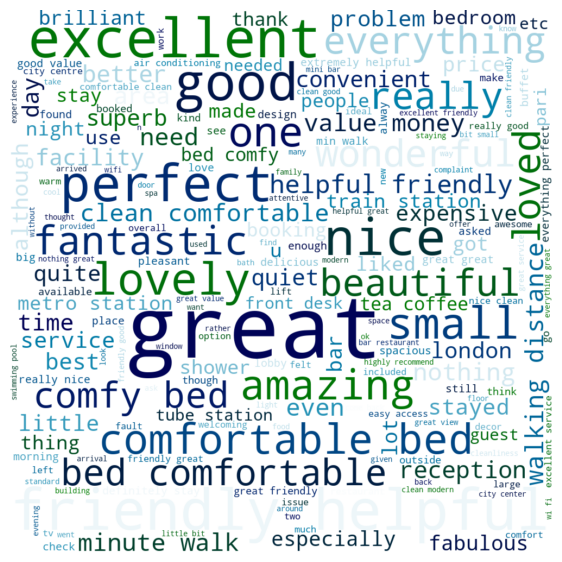

In [16]:
# WordCloud for Positive Review

wordCloud_generator(train_pos, 'white', 'ocean')

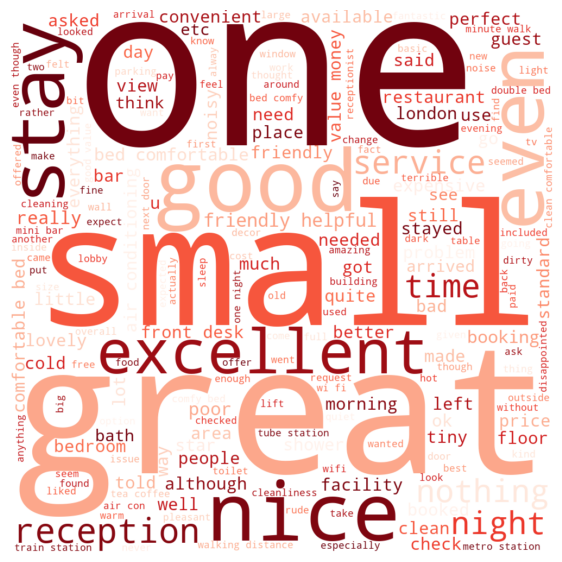

In [18]:
# WordCloud for Negative Review

wordCloud_generator(train_neg, 'white', 'Reds')

In [19]:
# Remove review before using the models
df = df.drop(['Review'], axis=1)

In [20]:
x = df.drop(['posneg', 'Reviewer_Score'], axis=1)
y = df['posneg']


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [21]:
# Random Forest Classifier
rfmodel = RandomForestClassifier(random_state=42)
rfmodel.fit(X_train, y_train)
prediction = rfmodel.predict(X_test)

classification_decision1 = (classification_report(y_test, rfmodel.predict(X_test)))
print("Random Forest Classifier")
print(classification_decision1)

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.73      0.76      0.75     24816
           1       0.76      0.73      0.74     25184

    accuracy                           0.74     50000
   macro avg       0.74      0.74      0.74     50000
weighted avg       0.74      0.74      0.74     50000



In [22]:
# Logistic Regression
lrmodel = LogisticRegression(random_state=42, max_iter=300)
lrmodel.fit(X_train, y_train)
pred_lr = lrmodel.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     24816
           1       0.77      0.75      0.76     25184

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000



In [ ]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)
pred_knn = knn_model.predict(X_test)

print("KNN")
print(classification_report(y_test, pred_knn))